Notebook: Gradient Boosting for EV Battery Life Estimation
1. Setup and Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


2. Synthetic Data Generation

In [6]:
np.random.seed(42)

# Number of samples
n_samples = 1000

# Simulate features
cycle_count = np.random.randint(100, 1000, n_samples)
avg_temp = np.random.normal(30, 5, n_samples)             # avg temp around 30°C ±5
max_voltage = np.random.uniform(4.0, 4.3, n_samples)
internal_resistance = 40 + 0.05 * cycle_count + np.random.normal(0, 2, n_samples)  # resistance grows with cycles
depth_of_discharge = np.random.uniform(50, 100, n_samples)
humidity = np.random.uniform(20, 60, n_samples)

# True battery life (RUL) with noise and nonlinear dependence
remaining_life = 2000 - 1.5 * cycle_count - 10 * (avg_temp - 25) \
                 - 20 * (internal_resistance - 40) + np.random.normal(0, 50, n_samples)

df = pd.DataFrame({
    'cycle_count': cycle_count,
    'avg_temp': avg_temp,
    'max_voltage': max_voltage,
    'internal_resistance': internal_resistance,
    'depth_of_discharge': depth_of_discharge,
    'humidity': humidity,
    'remaining_life': remaining_life
})

df.head()


,cycle_count,avg_temp,max_voltage,internal_resistance,depth_of_discharge,humidity,remaining_life
0,202,34.116763,4.096665,48.410567,56.100371,59.247262,1448.838811
1,535,40.262264,4.037570,65.113828,85.069164,38.650131,513.647150
2,960,31.255975,4.142301,89.767722,55.672041,51.677425,-501.189051
3,370,27.731017,4.034187,58.064453,99.845461,36.092282,976.233481
4,206,19.853846,4.145805,50.285600,59.172620,36.998141,1586.815357


3. Exploratory Data Analysis (EDA)

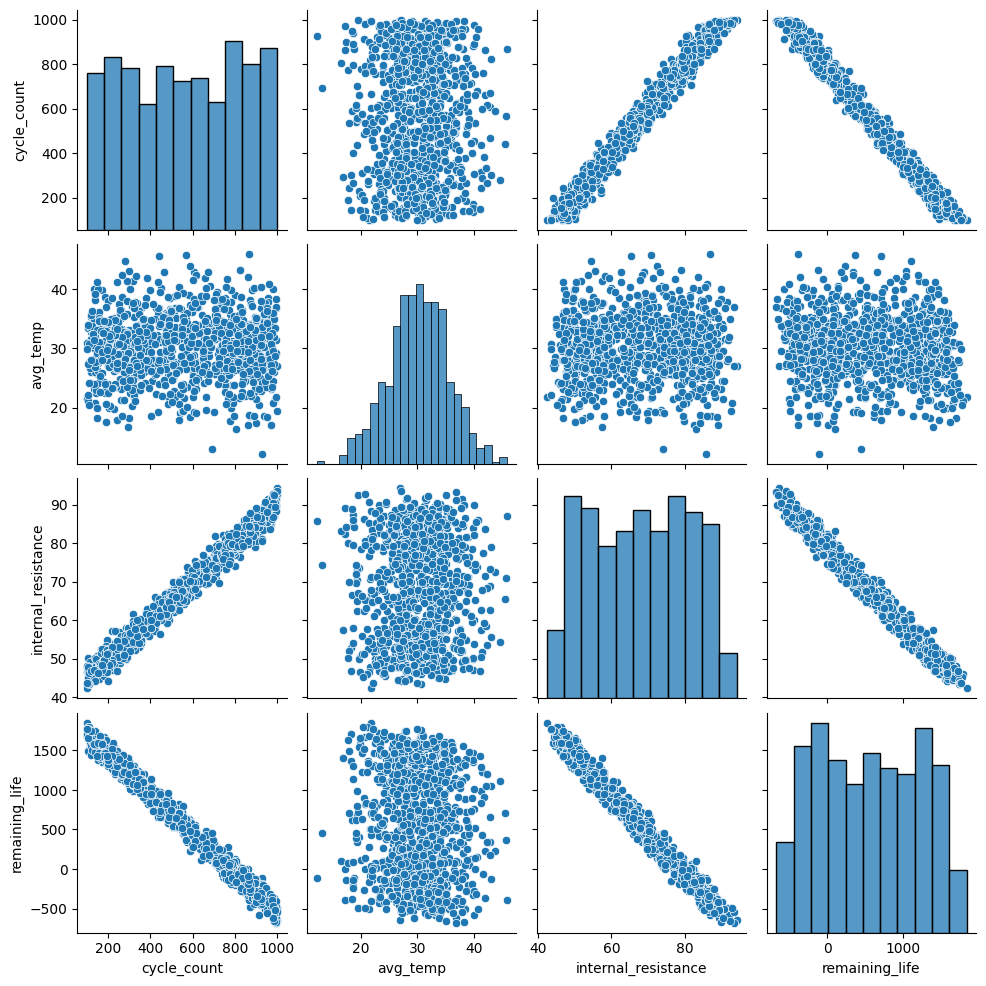

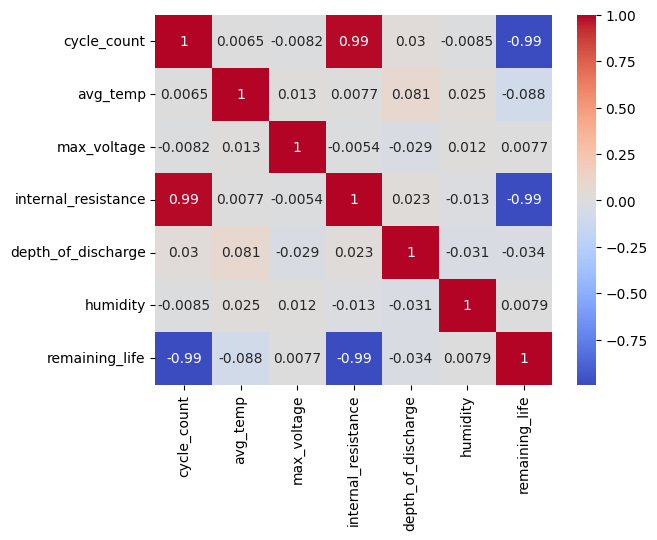

In [7]:
sns.pairplot(df, vars=['cycle_count', 'avg_temp', 'internal_resistance', 'remaining_life'])
plt.show()

sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()


4. Train-Test Split

In [8]:
X = df.drop(columns=['remaining_life'])
y = df['remaining_life']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


5. Training Gradient Boosting Regressor

In [9]:
gbr = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=4, random_state=42)
gbr.fit(X_train, y_train)


GradientBoostingRegressor(max_depth=4, n_estimators=200, random_state=42)

6. Evaluation

Test MSE: 3541.33
Test R2: 0.99


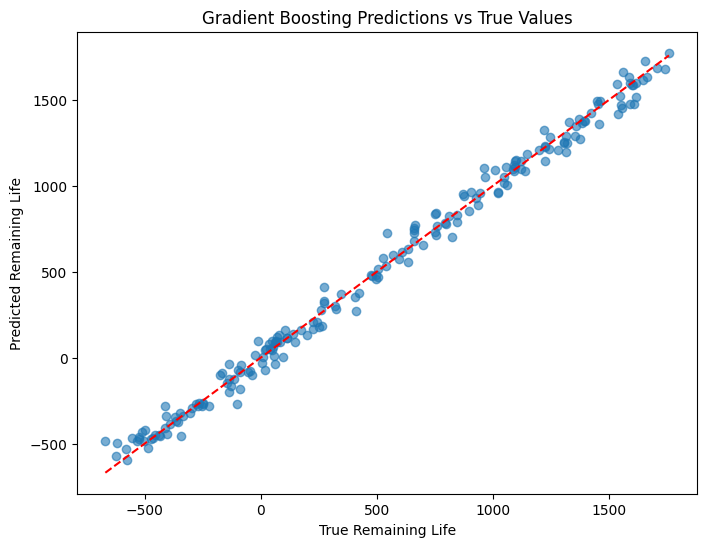

In [10]:
y_pred = gbr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.2f}")
print(f"Test R2: {r2:.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("Gradient Boosting Predictions vs True Values")
plt.show()


7. Residual Analysis

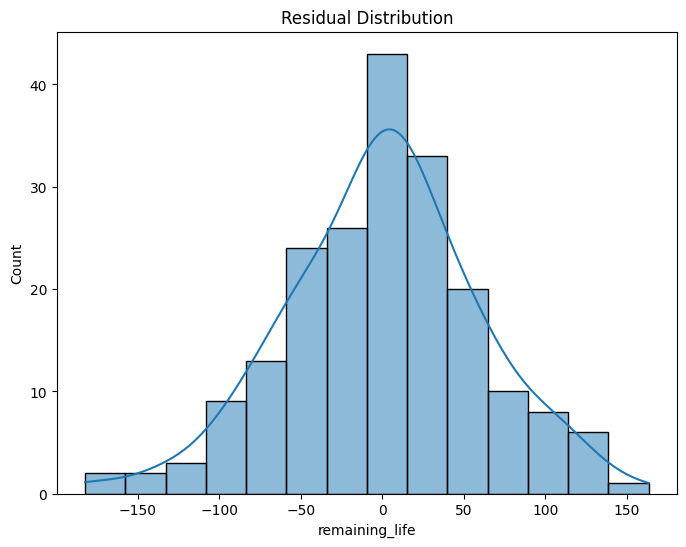

In [11]:
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()


8. Save Model for Deployment

In [12]:
import joblib
joblib.dump(gbr, 'ev_battery_life_gbr_model.pkl')
print("Model saved as 'ev_battery_life_gbr_model.pkl'")


Model saved as 'ev_battery_life_gbr_model.pkl'


In [18]:
# Import the core XGBoost API
import xgboost as xgb

# Import evaluation metrics from scikit-learn
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Create DMatrix objects, the optimized internal data structure used by XGBoost
# It is more efficient than raw arrays and supports missing values natively
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Define model parameters for regression
params = {
    'objective': 'reg:squarederror',  # Specifies that this is a regression task
    'learning_rate': 0.1,             # Step size shrinkage to prevent overfitting
    'max_depth': 5,                   # Maximum depth of each tree
    'eval_metric': 'rmse'             # Metric used to evaluate performance during training
}

# Train the XGBoost model with the specified parameters and training data
# num_boost_round specifies the number of boosting rounds (i.e., trees)
bst = xgb.train(params, dtrain, num_boost_round=100)

# Generate predictions using the trained model on the test set
y_pred = bst.predict(dtest)

# Evaluate the predictions using common regression metrics
print("MAE:", mean_absolute_error(y_test, y_pred))  # Mean Absolute Error
print("RMSE:", mean_squared_error(y_test, y_pred))  # Root Mean Squared Error


MAE: 45.37071632500761
RMSE: 3407.648038843946


In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Instantiate the model with similar hyperparameters
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=5,
    n_estimators=100  # equivalent to num_boost_round
)

# Fit the model directly on NumPy arrays or pandas DataFrames
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred = xgb_model.predict(X_test)

# Evaluate the predictions
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))


MAE: 45.37071632500761
RMSE: 3407.648038843946


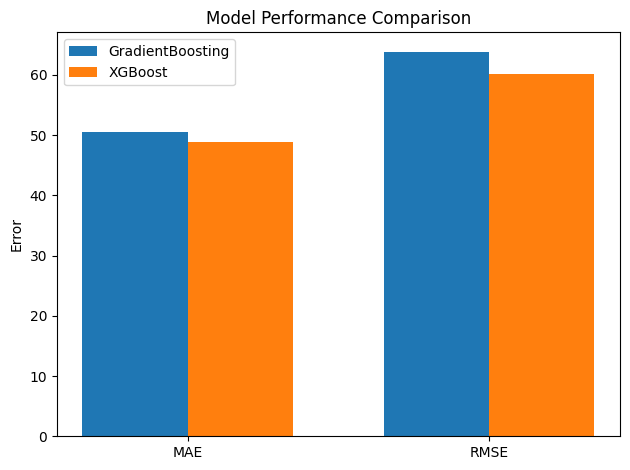

In [22]:
# Install XGBoost if not already installed (uncomment below if needed)
# !pip install xgboost

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
gbr_mae = mean_absolute_error(y_test, gbr_pred)
# Calculate RMSE by taking the square root of the MSE
gbr_rmse = mean_squared_error(y_test, gbr_pred) ** 0.5

# XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
# Calculate RMSE by taking the square root of the MSE
xgb_rmse = mean_squared_error(y_test, xgb_pred) ** 0.5

# Plotting
metrics = ['MAE', 'RMSE']
gbr_scores = [gbr_mae, gbr_rmse]
xgb_scores = [xgb_mae, xgb_rmse]
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, gbr_scores, width, label='GradientBoosting')
ax.bar(x + width/2, xgb_scores, width, label='XGBoost')

ax.set_ylabel('Error')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
plt.tight_layout()
plt.show()

Gradient Boosting Regressor:
MAE: 50.66
RMSE: 4082.36
R²: 0.89


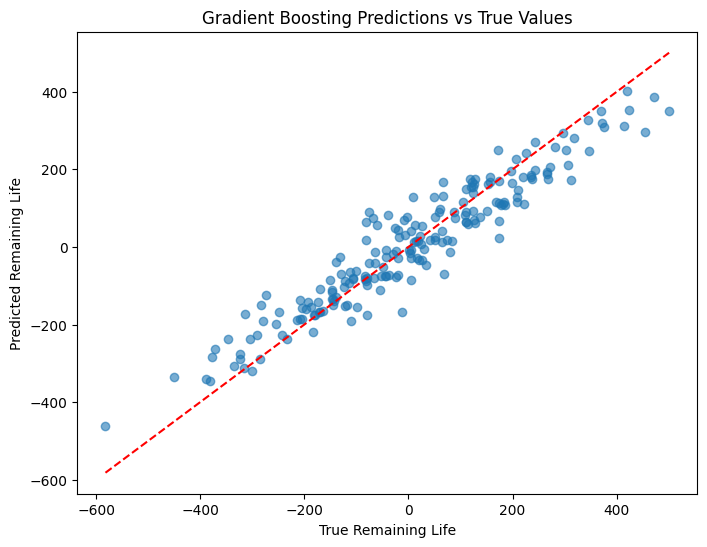


XGBoost Regressor:
MAE: 48.78
RMSE: 3625.81
R²: 0.91


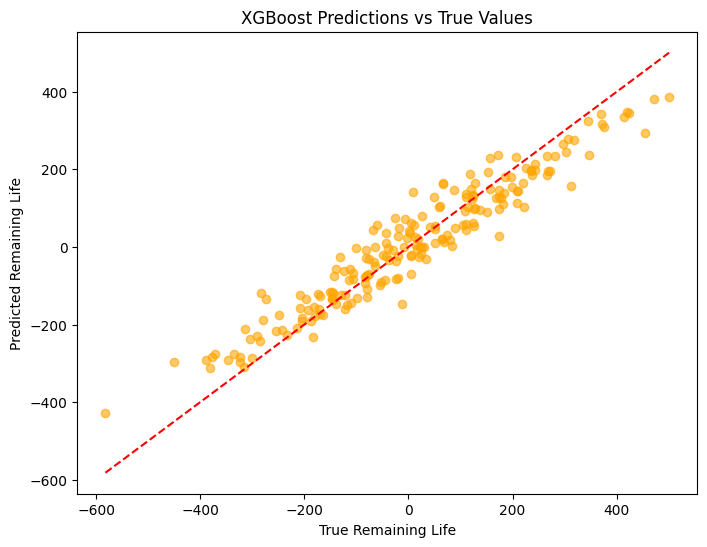

In [24]:
# Install XGBoost if not already installed
# !pip install xgboost

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Generate synthetic regression data
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_rmse = mean_squared_error(y_test, gbr_pred)

# Evaluate GBR
print("Gradient Boosting Regressor:")
print(f"MAE: {gbr_mae:.2f}")
print(f"RMSE: {gbr_rmse:.2f}")
print(f"R²: {r2_score(y_test, gbr_pred):.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, gbr_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("Gradient Boosting Predictions vs True Values")
plt.show()

# XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred)

# Evaluate XGB
print("\nXGBoost Regressor:")
print(f"MAE: {xgb_mae:.2f}")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"R²: {r2_score(y_test, xgb_pred):.2f}")

plt.figure(figsize=(8,6))
plt.scatter(y_test, xgb_pred, alpha=0.6, color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("XGBoost Predictions vs True Values")
plt.show()


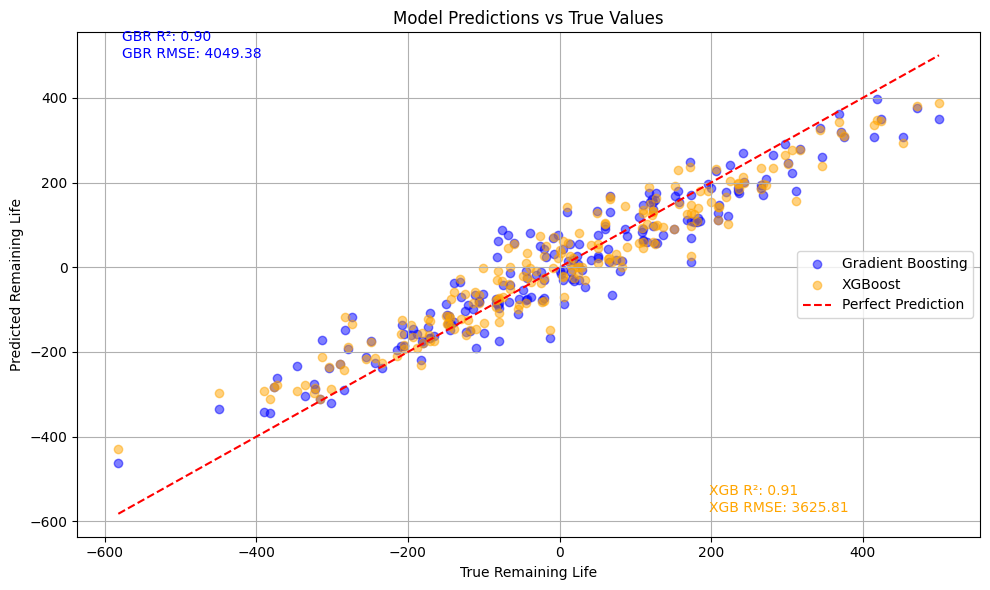

In [25]:
# Install if needed
# !pip install xgboost

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 1. Generate synthetic regression dataset
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Gradient Boosting Regressor
gbr = GradientBoostingRegressor(learning_rate=0.1, max_depth=5, n_estimators=100)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)

# 3. Train XGBoost Regressor
xgb = XGBRegressor(objective='reg:squarederror', learning_rate=0.1, max_depth=5, n_estimators=100, n_jobs=1)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

# 4. Compute Metrics
gbr_mae = mean_absolute_error(y_test, gbr_pred)
gbr_rmse = mean_squared_error(y_test, gbr_pred)
gbr_r2 = r2_score(y_test, gbr_pred)

xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred)
xgb_r2 = r2_score(y_test, xgb_pred)

# 5. Combined Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, gbr_pred, alpha=0.5, label='Gradient Boosting', color='blue')
plt.scatter(y_test, xgb_pred, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')

plt.xlabel("True Remaining Life")
plt.ylabel("Predicted Remaining Life")
plt.title("Model Predictions vs True Values")

# Annotations
plt.text(0.05, 0.95,
         f"GBR R²: {gbr_r2:.2f}\nGBR RMSE: {gbr_rmse:.2f}",
         transform=plt.gca().transAxes, fontsize=10, color='blue')

plt.text(0.7, 0.05,
         f"XGB R²: {xgb_r2:.2f}\nXGB RMSE: {xgb_rmse:.2f}",
         transform=plt.gca().transAxes, fontsize=10, color='orange')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
